<a href="https://www.kaggle.com/code/serdargundogdu/naive-bayes-classifier-filtering-spam-emails?scriptVersionId=117701854" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Filtering Spam Emails with Naive Bayes Classifier

## Business Problem - Question
### Our team receives too much email spam. We only want legitimate emails in our inbox. All incoming spam should be filtered out.

The first step is always formulating the question. It means is translating a business problem into a machine learning problem. We should classify all the emails. This is a classification problem and we are seperating the data. How do we train our algorithm when we're given text? We have to find a way to translate our text into a format that an algortihm can understand. We have to process the emails before handing them off to our algorithm to do the calculations.

## Machine Learning Problem - Formulate Question
### Take the raw emails and pre-process the text data. Then train a machine learning model that classifies the email as either spam or not-spam. Test the model's performance

## Gather Data
Data comes from Apache SpamAssassin

https://spamassassin.apache.org/downloads.cgi

A Corpus is defined as a large and structured set of texts. Plural of corpus is corpora :)

A document refers to a particular email.

# Notebook Imports

In [278]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import recall_score, precision_score, f1_score

%matplotlib inline
import seaborn as sns

# Constants

In [155]:
EXAMPLE_FILE = '/kaggle/input/spamdata/SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = '/kaggle/input/spamdata/SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = '/kaggle/input/spamdata/SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = '/kaggle/input/spamdata/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = '/kaggle/input/spamdata/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = '/kaggle/working/email-text-data.json'
WORD_ID_FILE = '/kaggle/working/word-by-id.csv'

TRAINING_DATA_FILE = '/kaggle/working/train-data.txt'
TEST_DATA_FILE = '/kaggle/working/test-data.txt'

WHALE_FILE = '/kaggle/input/spamdata/SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = '/kaggle/input/spamdata/SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = '/kaggle/input/spamdata/SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = '/kaggle/input/spamdata/SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = '/kaggle/input/spamdata/SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

TOKEN_SPAM_PROB_FILE = '/kaggle/working/prob-spam.txt'
TOKEN_HAM_PROB_FILE = '/kaggle/working/prob-nonspam.txt'
TOKEN_ALL_PROB_FILE = '/kaggle/working/prob-all-tokens.txt'

TEST_FEATURE_MATRIX = '/kaggle/working/test-features.txt'
TEST_TARGET_FILE = '/kaggle/working/test-target.txt'

# Reading Files

In [3]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [4]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [5]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [6]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [7]:
for i in generate_squares(5):
    print(i, end=' ->')

0 ->1 ->4 ->9 ->16 ->

## Email body extraction

In [8]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body

In [9]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [10]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))
spam_emails.head()

,MESSAGE,CATEGORY
00291.7aa227e74e89bdd529a3875459d0d5a2,This is a multi-part message in MIME format.\n...,1
00184.ead42d7ed872c504c79928a5f0a2b2eb,\n\n Do You Want To Teach and...,1
00399.cd1239166aa4d43f7c3127c3b48b3f18,This is a multi-part message in MIME format.\n...,1
00449.7d33f465cb813806296901ee541841d6,"<HTML>\n\n<TABLE id=AutoNumber2 style=""BORDER-...",1
00278.b62c5fc23a2f87760696cb9fa51f073c,"5, Meridian East\n\nLeicester LE3 2WZ \n\nLeic...",1


In [11]:
spam_emails.shape

(1898, 2)

In [12]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.shape

(3901, 2)

In [13]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


,MESSAGE,CATEGORY
00291.7aa227e74e89bdd529a3875459d0d5a2,This is a multi-part message in MIME format.\n...,1
00184.ead42d7ed872c504c79928a5f0a2b2eb,\n\n Do You Want To Teach and...,1
00399.cd1239166aa4d43f7c3127c3b48b3f18,This is a multi-part message in MIME format.\n...,1
00449.7d33f465cb813806296901ee541841d6,"<HTML>\n\n<TABLE id=AutoNumber2 style=""BORDER-...",1
00278.b62c5fc23a2f87760696cb9fa51f073c,"5, Meridian East\n\nLeicester LE3 2WZ \n\nLeic...",1


In [14]:
data.tail()

,MESSAGE,CATEGORY
00580.7dd943cb2a791ae9600144dee69f27b1,"For the past 2 days, nothing that I'm reportin...",0
01216.4dd33d22b4b0004c6b95b771c2881bcc,"On Mon, Aug 12, 2002 at 11:06:18PM +0000, Ang...",0
00742.ce72d7c8245e881d6e0ee5d8e9cfabab,"Well, it wouldn't be my own vanity list if I d...",0
00063.530734e4a37f26942ba8df3208912783,http://spackle.xidus.net/info.php\n\n\n\n>>Fro...,0
00025.84faba510a966c90f6ca7658260a7e4c,"Check out this. Its for compaq kit, but a pc's...",0


# Data Cleaning: Checking for Missing Values

In [15]:
# check if any message bodies are null
data['MESSAGE'].isnull().values.any()

False

In [16]:
type("")

str

In [17]:
len("")

0

In [18]:
my_var = None

In [19]:
type(my_var)

NoneType

In [20]:
# check if there are empty emails (string length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [21]:
(data.MESSAGE.str.len() == 0).sum()

3

In [22]:
# Challenge: how would you check the number of entries with null/None values?
data.MESSAGE.isnull().sum()

0

### Locate empty emails

In [23]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [24]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [35]:
data[4608:4611]

,MESSAGE,CATEGORY
00972.9d730aeba4cc56041575ddcd8d324447,">>>>> ""R"" == Robert Harley <harley@argote.ch> ...",0
01260.c273caa5ba806db5a6dfd87261b397a1,FYI..\n\n\n\n----- Original Message -----\n\nF...,0
01345.c40d5798193a4a060ec9f3d2321e37e4,\n\nSecurityFocus Linux Newsletter #92\n\n----...,0


# Remove System File Entries from Dataframe

In [37]:
data.drop(['cmds'], inplace=True)

data[4608:4611]

,MESSAGE,CATEGORY
01297.146414518ef3b2597af35179575faa9a,Update of /cvsroot/spamassassin/spamassassin/s...,0
00847.d369bf288bfbf485becfb13b7d625dca,"On Wed, 2002-07-24 at 07:09, Justin Mason wrot...",0
00357.e7d56ee8cf689fa0a5276446772fa8ec,Quoting Nick Murtagh (nickm@go2.ie):\n\n> On M...,0


In [38]:
data.shape

(5796, 2)

# Add Document IDs to Track Emails in Dataset

In [39]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [40]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,This is a multi-part message in MIME format.\n...,1,00291.7aa227e74e89bdd529a3875459d0d5a2
1,\n\n Do You Want To Teach and...,1,00184.ead42d7ed872c504c79928a5f0a2b2eb
2,This is a multi-part message in MIME format.\n...,1,00399.cd1239166aa4d43f7c3127c3b48b3f18
3,"<HTML>\n\n<TABLE id=AutoNumber2 style=""BORDER-...",1,00449.7d33f465cb813806296901ee541841d6
4,"5, Meridian East\n\nLeicester LE3 2WZ \n\nLeic...",1,00278.b62c5fc23a2f87760696cb9fa51f073c


In [41]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,"For the past 2 days, nothing that I'm reportin...",0,00580.7dd943cb2a791ae9600144dee69f27b1
5792,"On Mon, Aug 12, 2002 at 11:06:18PM +0000, Ang...",0,01216.4dd33d22b4b0004c6b95b771c2881bcc
5793,"Well, it wouldn't be my own vanity list if I d...",0,00742.ce72d7c8245e881d6e0ee5d8e9cfabab
5794,http://spackle.xidus.net/info.php\n\n\n\n>>Fro...,0,00063.530734e4a37f26942ba8df3208912783
5795,"Check out this. Its for compaq kit, but a pc's...",0,00025.84faba510a966c90f6ca7658260a7e4c


# Save to File using Pandas

In [42]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualised (Pie Charts)

In [43]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [44]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

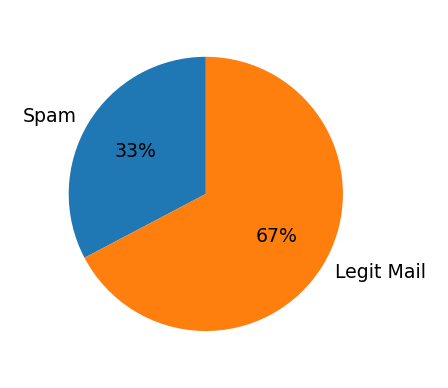

In [45]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%')
plt.show()

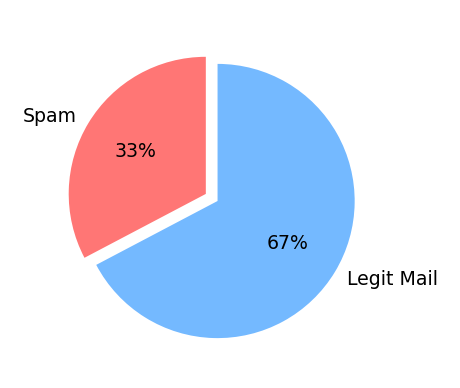

In [46]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.1])
plt.show()

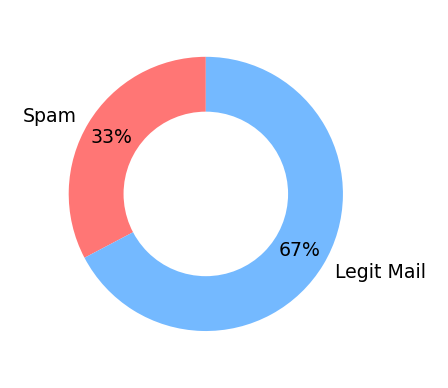

In [47]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

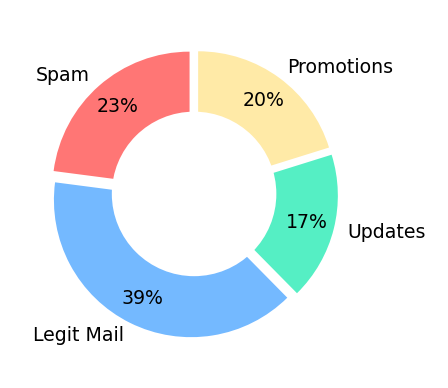

In [48]:
category_names = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
custom_colours = ['#ff7675', '#74b9ff', '#55efc4', '#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8, explode=offset)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing

### Text Pre-Processing

In [49]:
# convert to lower case
msg = 'All work and no play makes Jack a dull boy.'
msg.lower()

'all work and no play makes jack a dull boy.'

### Download the NLTK Resources (Tokenizer & Stopwords)

In [50]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [51]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to /usr/share/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to /usr/share/nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

## Tokenising

In [53]:
msg = 'All work and no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

## Removing Stop Words 

In [54]:
stop_words = set(stopwords.words('english'))

In [55]:
type(stop_words)

set

In [56]:
if 'this' in stop_words: print('Found it!')

Found it!


In [57]:
# Challenge: print out 'Nope. Not in here' if the word "hello" is not contained in stop_words

In [58]:
if 'hello' not in stop_words: print('Nope. Not in here')

Nope. Not in here


In [59]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = []
# Challenge: append non-stop words to filtered_words
for word in words:
    if word not in stop_words:
        filtered_words.append(word)

print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


## Word Stems and Stemming

In [60]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
      Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')


filtered_words = []
# Challenge: append non-stop words to filtered_words
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


## Removing Punctuation

In [61]:
'p'.isalpha()

True

In [62]:
'?'.isalpha()

False

In [63]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. ??? \
      Nobody expects the Spanish Inquisition!'

words = word_tokenize(msg.lower())
stemmer = SnowballStemmer('english')
filtered_words = []

for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing HTML tags from Emails

In [64]:
soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')
print(soup.prettify())

This is a multi-part message in MIME format.



------=_NextPart_000_C16F3_01C260C3.2978B160

Content-Type: text/plain;

	charset="Windows-1252"

Content-Transfer-Encoding: quoted-printable



 An Additional Income Stream

 from your current book of business!

  =09

 	  	 	 =09

 	 Agent Commission:

$92,000=20

 Client:

 87-year-old male

 82-Year-old female



 Result:

 $2,300,000 second to die

 policy, minimal cash value.  Policy was no longer

 required. Insured utilized a

 life settlement and received

 $300,000. Agent Commission:

$30,000=20

 Client:

 70-year-old male with health complications



 Result:

 $1,000,000 policy with small

 cash value. Insured utilized

 a life settlement and

 received $300,000. Agent Commission:

$90,000=20



 Client:

 89-year-old female



 Result:

 $2,000,000 policy with an

 annual premium of $110,000.

 Policy expires at age 95.

 Insured utilized a life

 settlement and received

 $325,000.=20

 	  	 	 =09

=20



Multiple opportuni

In [65]:
soup.get_text()

'This is a multi-part message in MIME format.\n\n\n\n------=_NextPart_000_C16F3_01C260C3.2978B160\n\nContent-Type: text/plain;\n\n\tcharset="Windows-1252"\n\nContent-Transfer-Encoding: quoted-printable\n\n\n\n An Additional Income Stream\n\n from your current book of business!\n\n  =09\n\n \t  \t \t =09\n\n \t Agent Commission:\n\n$92,000=20\n\n Client:\n\n 87-year-old male\n\n 82-Year-old female\n\n\n\n Result:\n\n $2,300,000 second to die\n\n policy, minimal cash value.  Policy was no longer\n\n required. Insured utilized a\n\n life settlement and received\n\n $300,000. Agent Commission:\n\n$30,000=20\n\n Client:\n\n 70-year-old male with health complications\n\n\n\n Result:\n\n $1,000,000 policy with small\n\n cash value. Insured utilized\n\n a life settlement and\n\n received $300,000. Agent Commission:\n\n$90,000=20\n\n\n\n Client:\n\n 89-year-old female\n\n\n\n Result:\n\n $2,000,000 policy with an\n\n annual premium of $110,000.\n\n Policy expires at age 95.\n\n Insured utilized

## Functions for Email Processing

In [66]:
def clean_message(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [67]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [68]:
# Challenge: Modify function to remove HTML tags. Then test on Email with DOC_ID 2. 
def clean_msg_no_html(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
#             filtered_words.append(word) 
    
    return filtered_words

In [69]:
clean_msg_no_html(data.at[2, 'MESSAGE'])

['messag',
 'mime',
 'format',
 'addit',
 'incom',
 'stream',
 'current',
 'book',
 'busi',
 'agent',
 'commiss',
 'client',
 'male',
 'femal',
 'result',
 'second',
 'die',
 'polici',
 'minim',
 'cash',
 'valu',
 'polici',
 'longer',
 'requir',
 'insur',
 'util',
 'life',
 'settlement',
 'receiv',
 'agent',
 'commiss',
 'client',
 'male',
 'health',
 'complic',
 'result',
 'polici',
 'small',
 'cash',
 'valu',
 'insur',
 'util',
 'life',
 'settlement',
 'receiv',
 'agent',
 'commiss',
 'client',
 'femal',
 'result',
 'polici',
 'annual',
 'premium',
 'polici',
 'expir',
 'age',
 'insur',
 'util',
 'life',
 'settlement',
 'receiv',
 'multipl',
 'opportun',
 'earn',
 'commiss',
 'one',
 'strategi',
 'elderli',
 'health',
 'person',
 'financi',
 'need',
 'circumst',
 'chang',
 'sinc',
 'origin',
 'life',
 'polici',
 'issu',
 'opportun',
 'creat',
 'addit',
 'incom',
 'stream',
 'life',
 'settlement',
 'earn',
 'referr',
 'fee',
 'life',
 'settlement',
 'transact',
 'trailer',
 'commiss',

# Apply Cleaning and Tokenisation to all messages

### Slicing Dataframes and Series & Creating Subsets

In [70]:
data.iat[2, 2]

'00399.cd1239166aa4d43f7c3127c3b48b3f18'

In [71]:
data.iloc[5:11]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,Get your favorite Poker action at http://www.m...,1,00358.2cf55d91739f3530d1f4bc8bc9bc0b12
6,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00032.7b07a09236ce9feb12d80197144d3206
7,"<html>\n\n\n\n<head>\n\n<meta http-equiv=3D""Co...",1,00030.0c9cdd9d4025bd55dac02719ec8d29dc
8,ATTN:\n\n\n\nI am Bulawa Mulete JR. the son of...,1,00220.cf7d03e161582887dc589229e2896e26
9,IMPORTANT DOMAIN INFORMATION:\n\n\n\n\n\nThe n...,1,00452.ed43fc952c31c82aa29646edfbecb03f
10,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00020.29725cf331fc21e18a1809e7d8b27332


In [72]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message)

In [73]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]
        
len(flat_list)

1173

In [74]:
flat_list

['messag',
 'mime',
 'format',
 'tba',
 'doctor',
 'walk',
 'walk',
 'diabet',
 'case',
 'case',
 'male',
 'age',
 'face',
 'type',
 'diabet',
 'treat',
 'insulin',
 'pump',
 'diagnos',
 'age',
 'hospit',
 'diabet',
 'complic',
 'issu',
 'standard',
 'male',
 'age',
 'face',
 'take',
 'micronas',
 'glucophag',
 'issu',
 'super',
 'standard',
 'case',
 'case',
 'femal',
 'age',
 'face',
 'insulin',
 'issu',
 'super',
 'standard',
 'male',
 'age',
 'face',
 'diabet',
 'control',
 'diet',
 'issu',
 'super',
 'standard',
 'click',
 'provid',
 'detail',
 'tough',
 'case',
 'http',
 'call',
 'doctor',
 'case',
 'detail',
 'cure',
 'agent',
 'tough',
 'case',
 'ext',
 'pleas',
 'fill',
 'form',
 'inform',
 'name',
 'phone',
 'citi',
 'state',
 'tennesse',
 'brokerag',
 'agenc',
 'http',
 'want',
 'anyon',
 'receiv',
 'mail',
 'wish',
 'profession',
 'commun',
 'sent',
 'insur',
 'profession',
 'remov',
 'mail',
 'list',
 'repli',
 'messag',
 'instead',
 'go',
 'http',
 'legal',
 'notic',
 'ht

In [75]:
%%time

# use apply() on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:408: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning


CPU times: user 43.7 s, sys: 45.6 ms, total: 43.8 s
Wall time: 43.8 s


In [76]:
nested_list.tail()

DOC_ID
5791    [past, day, noth, report, seem, databas, repor...
5792    [mon, aug, angl, puglisi, wrote, michel, alexa...
5793    [well, would, vaniti, list, forward, least, li...
5794    [http, websit, spackl, design, flexibl, archit...
5795    [check, compaq, kit, pc, pc, http, articl, hop...
Name: MESSAGE, dtype: object

### Using Logic to Slice Dataframes

In [77]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [78]:
data[data.CATEGORY == 1].tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
1891,"\n\n<HTML>\n\n<BODY>\n\n<FONT face=3D""MS Sans ...",1,00143.95e60a4160434f341761931c65844a38
1892,\n\n--=====================_889472414==_\n\nCo...,1,00179.ef2f7cf60806a96b59f4477b025580ee
1893,"<HR>\n\n<html>\n\n<div bgcolor=3D""#FFFFCC"">\n\...",1,01119.343c5318a6ef39de4aea0f081009f391
1894,\n\nHello Unlimited International Telephone Ca...,1,00183.47b495fc7ebd7807affa6425de6419b3
1895,<HTML><HEAD><TITLE>New Web Technology</TITLE>\...,1,01078.58e6f465de71680b96d9d750b7200a59


In [79]:
# Challenge: create two variables (doc_ids_spam, doc_ids_ham) which 
# hold onto the indices for the spam and the non-spam emails respectively. 

In [80]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [81]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

### Subsetting a Series with an Index

In [82]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [83]:
type(nested_list)

pandas.core.series.Series

In [84]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [85]:
nested_list_ham.shape

(3900,)

In [86]:
nested_list_ham.tail()

DOC_ID
5791    [past, day, noth, report, seem, databas, repor...
5792    [mon, aug, angl, puglisi, wrote, michel, alexa...
5793    [well, would, vaniti, list, forward, least, li...
5794    [http, websit, spackl, design, flexibl, archit...
5795    [check, compaq, kit, pc, pc, http, articl, hop...
Name: MESSAGE, dtype: object

In [87]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [88]:
# Challenge: use python list comprehension and then find the total number of 
# words in our cleaned dataset of spam email bodies. Also find the total number of 
# words in normal emails in the dataset. Then find the 10 most common words used in 
# spam. Also, find the 10 most common words used in non-spam messages. 

In [89]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0] # total number of unique words in the non-spam messages

20815

In [90]:
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [91]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0] # total number of unique words in the spam messages

13242

In [92]:
spammy_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

# Creating a Word Cloud

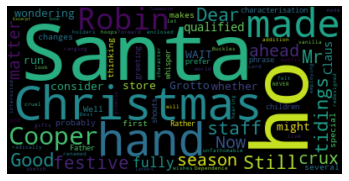

In [94]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [95]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [96]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [97]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [98]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

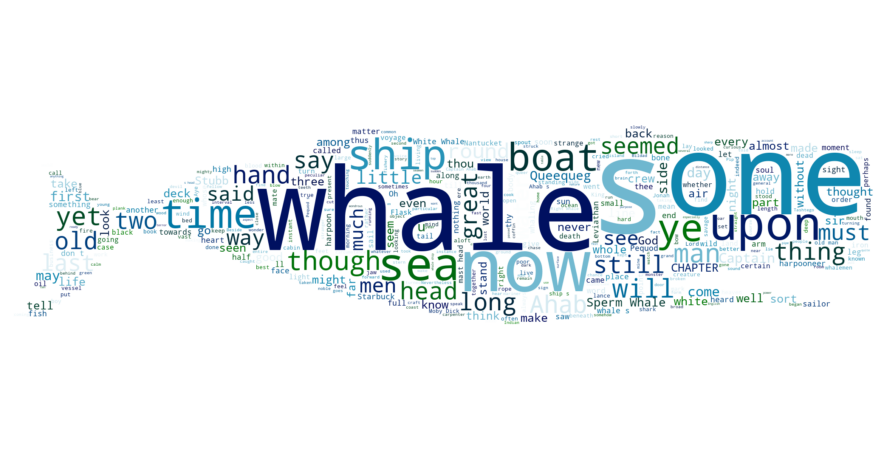

In [99]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=400, colormap='ocean')

word_cloud.generate(novel_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [100]:
rgb_array.shape

(1024, 2048, 3)

In [101]:
rgb_array[1023, 2047]

array([255, 255, 255], dtype=uint8)

In [102]:
rgb_array[500, 1000]

array([0, 0, 0], dtype=uint8)

In [103]:
# Challenge: use the skull image in the lesson resources to create a word cloud
# for Shakespeare's play Hamlet

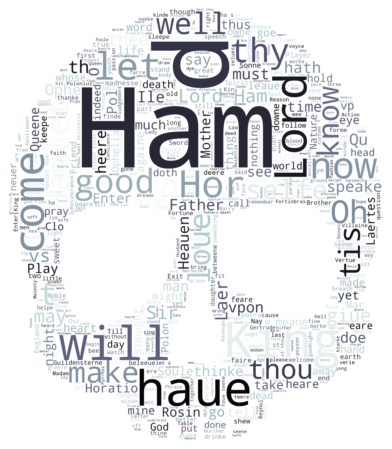

In [104]:
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in hamlet_corpus]
hamlet_as_string = ' '.join(word_list)

skull_icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=skull_icon.size, color=(255, 255, 255))
image_mask.paste(skull_icon, box=skull_icon)
rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                      colormap='bone', max_words=600)

word_cloud.generate(hamlet_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word Cloud of Ham and Spam Messages

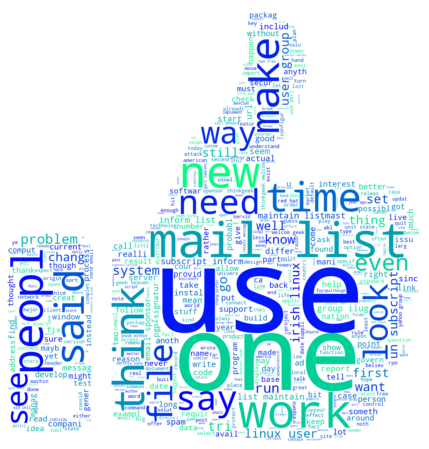

In [105]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=500, colormap='winter')

word_cloud.generate(ham_str)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [106]:
# Challenge: Look at the word cloud documentation. Use the custom font included in the 
# lesson resources instead of the default font and create a word cloud of the spammy words

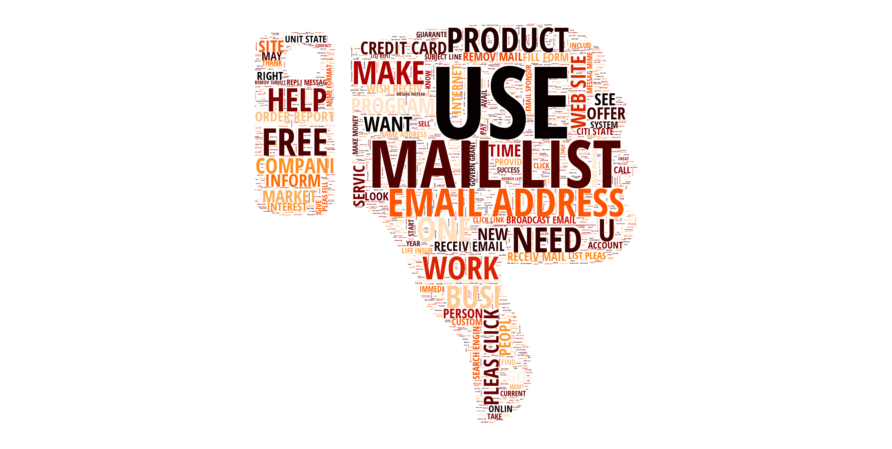

In [107]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_font_size=300,
                      max_words=2000, colormap='gist_heat', font_path=CUSTOM_FONT_FILE)

word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary & Dictionary

In [108]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:408: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning


In [109]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words', unique_words.shape[0])
unique_words.head()

Nr of unique words 27334


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [110]:
# Challenge: Create subset of the series called 'frequent_words' that only contains
# the most common 2,500 words out of the total. Print out the top 10 words

In [111]:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words: \n', frequent_words[:10])

Most common words: 
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


## Create Vocabulary DataFrame with a WORD_ID

In [112]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the Vocabulary as a CSV File

In [113]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

# Exercise: Checking if a Word is Part of the Vocabulary

In [114]:
# Challenge: Write a line of code that checks if a particular word is part 
# of the vocabulary. Your code should return True if the word is among the 
# 2,500 words that comprise the vocabulary, and False otherwise. Check these words:
# 'machine'
# 'learning'
# 'fun'
# 'learn'
# 'data'
# 'science'
# 'app'
# 'brewery'

In [115]:
any(vocab.VOCAB_WORD == 'machine') # inefficient

False

In [116]:
'brew' in set(vocab.VOCAB_WORD) # better way

False

# Exercise: Find the Email with the Most Number of Words

In [117]:
# Challenge: Print out the number of words in the longest email (after cleaning & stemming).
# Note the longest email's position in the list of cleaned emails. Print out the stemmed
# list of words in the longest email. Print out the longest email from the data dataframe.

# Hint: use the len() function and practice list comprehension

In [118]:
# For loop
clean_email_lengths = []
for sublist in stemmed_nested_list:
    clean_email_lengths.append(len(sublist))

In [119]:
# Python List Comprehension
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
print('Nr words in the longest email:', max(clean_email_lengths))

Nr words in the longest email: 7671


In [120]:
print('Email position in the list (and the data dataframe)', np.argmax(clean_email_lengths))

Email position in the list (and the data dataframe) 4826


In [121]:
stemmed_nested_list[np.argmax(clean_email_lengths)]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [122]:
data.at[np.argmax(clean_email_lengths), 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate Features & a Sparse Matrix

### Creating a DataFrame with one Word per Column

In [123]:
type(stemmed_nested_list)

pandas.core.series.Series

In [124]:
type(stemmed_nested_list.tolist())

list

In [125]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,messag,mime,format,tba,doctor,walk,walk,diabet,case,case,...,None,None,None,None,None,None,None,None,None,None
1,want,teach,grow,rich,motiv,qualifi,commun,person,train,minut,...,None,None,None,None,None,None,None,None,None,None
2,messag,mime,format,addit,incom,stream,current,book,busi,agent,...,None,None,None,None,None,None,None,None,None,None
3,never,pay,retail,royal,vega,onlin,casino,beat,hous,royal,...,None,None,None,None,None,None,None,None,None,None
4,meridian,east,leicest,leicest,citi,unit,kingdom,date,capt,john,...,None,None,None,None,None,None,None,None,None,None


In [126]:
word_columns_df.shape

(5796, 7671)

### Splitting the Data into a Training and Testing Dataset

In [127]:
# Challenge: Can you split the data into a training and testing set? Set the test size at 30%. 
# The training data should include 4057 emails. Use a seed value of 42 to shuffle the data. 
# What should the target values be? 

In [128]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY,
                                                   test_size=0.3, random_state=42)

In [129]:
print('Nr of training samples', X_train.shape[0])
print('Fraction of training set', X_train.shape[0] / word_columns_df.shape[0])

Nr of training samples 4057
Fraction of training set 0.6999654934437544


In [130]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,tue,aug,david,raistrick,wrote,actual,answer,justin,question,one,...,None,None,None,None,None,None,None,None,None,None
4727,mon,aug,anthoni,wrote,net,howev,realis,window,alter,hw,...,None,None,None,None,None,None,None,None,None,None
5022,use,perl,daili,newslett,issu,damian,conway,speak,london,meet,...,None,None,None,None,None,None,None,None,None,None
3504,url,http,date,oracl,googl,answer,multipl,choic,question,amazingli,...,None,None,None,None,None,None,None,None,None,None
3921,pm,gari,lawrenc,murphi,wrote,car,meter,across,mayb,meter,...,None,None,None,None,None,None,None,None,None,None


In [131]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

### Create a Sparse Matrix for the Training Data

In [132]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index[3])

str

In [133]:
word_index.get_loc('thu')

393

In [134]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [135]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

CPU times: user 12min 48s, sys: 711 ms, total: 12min 49s
Wall time: 12min 50s


In [136]:
sparse_train_df[:5]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,683
1,0,4844,1,253
2,0,4844,1,1042
3,0,4844,1,37
4,0,4844,1,173


In [137]:
sparse_train_df.shape

(429091, 4)

In [138]:
sparse_train_df[-5:]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
429086,1,860,1,381
429087,1,860,1,1453
429088,1,860,1,18
429089,1,860,1,21
429090,1,860,1,198


### Combine Occurrences with the Pandas groupby() Method

In [139]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      0       1              2
       2       1              2
       5       1              4
       10      1              3
       15      1              2

In [140]:
vocab.at[0, 'VOCAB_WORD']

'http'

In [141]:
data.MESSAGE[0]

'This is a multi-part message in MIME format.\n\n\n\n------=_NextPart_000_143B1F_01C25A7A.A80CB430\n\nContent-Type: text/plain;\n\n\tcharset="Windows-1252"\n\nContent-Transfer-Encoding: quoted-printable\n\n\n\n The TBA Doctor Walks the Walk... On Diabetes!\n\n =20\n\n =20\n\n\n\n\n\nCase 1:\t Case 2:\t=20\n\n? Male age 37\n\n? Nonsmoker=20\n\n? $500,000 Face\n\n? Type 1 Diabetic - Treated with Insulin Pump\n\n? Diagnosed at age 23\n\n? Hospitalized in \'95, \'96 and \'98 with\n\n  "Diabetic Complications"\n\n? Issued Standard \t? Male age 51\n\n? Nonsmoker=20\n\n? $1,200,000 Face\n\n? 6\'0", 237lbs=20\n\n? Takes Micronase and Glucophage\n\n? Issued Super Standard =09\n\nCase 3:\t Case 4:\t=20\n\n? Female age 60\n\n? Nonsmoker=20\n\n? $2,000,000 Face\n\n? 5\'5", 165lbs=20\n\n? Insulin Dependent=20\n\n? Issued Super Standard \t? Male age 45\n\n? Nonsmoker=20\n\n? $875,000 Face\n\n? 6\'4", 275lbs\n\n? Diabetes Controlled by Diet\n\n? Issued Super Standard =09\n\nClick here to provide the 

In [142]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,0,1,2
1,0,2,1,2
2,0,5,1,4
3,0,10,1,3
4,0,15,1,2


In [143]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
260357,5795,1946,0,1
260358,5795,2094,0,1
260359,5795,2225,0,1
260360,5795,2248,0,1
260361,5795,2332,0,1


In [144]:
vocab.at[1923, 'VOCAB_WORD']

'mirror'

In [145]:
data.MESSAGE[5795]

"Check out this. Its for compaq kit, but a pc's a pc ;--)\n\n\n\nhttp://www.geocities.com/rlcomp_1999/procedures/kickstart-rh70.html\n\n\n\nThere are other articles too.\n\n\n\nHope that helps,\n\n\n\nCW\n\n----------------\n\nHow many Redhat admins out there use the redhat kickstart?\n\nIf you don't use it, how do you install redhat on all your \n\nworkstations, do you do it by hand, with the cds?\n\n\n\nAs we are looking at using Linux at work, I'm looking\n\ninto setting up the kickstart. There doesn't seem to\n\nbe a lot of documentation around about it.\n\n\n\nDoes anybody know if it would be possible to do the following:\n\nGet the machine to boot using DHCP and read it's kickstart\n\nconfig file from teh DHCP server and in this config file\n\nhave the machine configured to use a static IP, so that when\n\nthe machine is rebooted it will come up with it's new IP.\n\n\n\nAlso, There was no driver on the redhat network install flopopy\n\nfor the network card in the machine I'm inst

In [146]:
train_grouped.shape

(260362, 4)

### Save Training Data as .txt File

In [147]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [148]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

# Challenge

Can you create a sparse matrix for the test data. Group the occurrences of the same word in the same email. Then save the data as a .txt file. 

In [150]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,see,subject,regard,germani,matthia,mail,list,http,None,None,...,None,None,None,None,None,None,None,None,None,None
4220,brent,welch,date,wed,aug,robert,elz,said,also,goe,...,None,None,None,None,None,None,None,None,None,None
2484,glm,wherea,polit,brochur,statist,clearli,show,glm,greater,senseless,...,None,None,None,None,None,None,None,None,None,None
2418,sorri,neighbor,never,met,pigeonhol,within,one,minut,ask,question,...,None,None,None,None,None,None,None,None,None,None
5110,tue,aug,justin,shore,wrote,ah,learn,someth,new,everi,...,None,None,None,None,None,None,None,None,None,None


In [151]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

In [152]:
X_test.shape

(1739, 7671)

In [153]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: user 5min 30s, sys: 343 ms, total: 5min 30s
Wall time: 5min 30s


In [156]:
sparse_test_df.shape

(203516, 4)

In [157]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,0,1,1
1,8,2,1,1
2,8,3,1,1
3,8,5,1,2
4,8,7,1,1


In [158]:
test_grouped.shape

(115785, 4)

In [159]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

# Pre-Processing Subtleties and Checking your Understanding

Challenge: We started with 5796 emails. We split it into 4057 emails for training and 1739 emails for testing. 

How many individual emails were included in the testing .txt file? Count the number in the test_grouped DataFrame. After splitting and shuffling our data, how many emails were included in the X_test DataFrame? Is the number the same? If not, which emails were excluded and why? Compare the DOC_ID values to find out.

In [160]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [161]:
len(test_doc_ids)

1725

In [162]:
len(X_test)

1739

In [163]:
set(X_test.index.values) - test_doc_ids # Excluded emails after pre-processing

{19, 44, 151, 203, 339, 373, 425, 437, 582, 1047, 1222, 1294, 1323, 1726}

In [164]:
data.MESSAGE[14]

'<html>\n\n\n\n\n\n\n\n<body>\n\n\n\n<div align=3D"left">\n\n  <table border=3D"1" cellpadding=3D"5" style=3D"border-collapse: collapse=\n\n" bordercolor=3D"#111111" width=3D"527" height=3D"299" id=3D"AutoNumber1">\n\n    <tr>\n\n      <td width=3D"527" height=3D"299" rowspan=3D"2" bgcolor=3D"#C0C0C0">\n\n      <p align=3D"center"><b><font face=3D"Verdana" size=3D"5">Copy\n\n      <font color=3D"#ff0000">ANY DVD</font> with a CD-R Burner!</font></b=\n\n></p>\n\n      <p align=3D"left"><font face=3D"Verdana" size=3D"2"><b>DVD Wizard Pr=\n\no </b>is the \n\n      most technologically advanced method of DVD reproduction ever availa=\n\nble!\n\n      <b><font color=3D"#ff0000">Do not be fooled</font></b> by other fly =\n\nby night \n\n      websites offering outdated information.<br>\n\n      </font><br>\n\n      <font face=3D"Verdana" size=3D"2">Our package will show you how to <=\n\nb>backup \n\n      any DVD</b> or <b>VHS cassette</b> using a <b><font color=3D"#ff0000=\n\n">CD-R \n\n   

In [165]:
data.loc[14]

MESSAGE      <html>\n\n\n\n\n\n\n\n<body>\n\n\n\n<div align...
CATEGORY                                                     1
FILE_NAME               00201.00020fc9911604f6cae7ae0f598ad29d
Name: 14, dtype: object

In [166]:
clean_msg_no_html(data.at[14, 'MESSAGE'])

['copi',
 'dvd',
 'burner',
 'dvd',
 'wizard',
 'technolog',
 'advanc',
 'method',
 'dvd',
 'reproduct',
 'ever',
 'ble',
 'fool',
 'fli',
 'night',
 'websit',
 'offer',
 'outdat',
 'inform',
 'packag',
 'show',
 'b',
 'backup',
 'dvd',
 'vh',
 'cassett',
 'use',
 'burner',
 'go',
 'show',
 'backup',
 'dvd',
 'use',
 'burner',
 'well',
 'make',
 'qualiti',
 'backup',
 'person',
 'dvd',
 'vh',
 'cassett',
 'creat',
 'dvd',
 'librari',
 'never',
 'worri',
 'scratch',
 'lose',
 'dvd',
 'dvd',
 'wizard',
 'pro',
 'complet',
 'unlik',
 'anyth',
 'titor',
 'offer',
 'fulli',
 'guarante',
 'order',
 'today',
 'wo',
 'disappoint',
 'limit',
 'time',
 'sold',
 'packag',
 'much',
 'limit',
 'ime',
 'offer',
 'instant',
 'access',
 'go',
 'order',
 'copi',
 'today',
 'email',
 'address',
 'obtain',
 'list',
 'mrsa',
 'list',
 'purchas',
 'code',
 'wish',
 'subscrib',
 'list',
 'pleas',
 'click',
 'press',
 'send',
 'e',
 'remov',
 'previous',
 'unsubscrib',
 'still',
 'receiv',
 'messag',
 'may',

In [167]:
data.MESSAGE[1096]

'<HTML><FONT  COLOR=3D"#ff00ff" BACK=3D"#ffffff" style=3D"BACKGROUND-COLOR: =\n\n#ffffff" SIZE=3D3 PTSIZE=3D12> &nbsp;<B><!--#rotate>Terific!!   Instantly =\n\n</FONT><FONT  COLOR=3D"#ff0000" BACK=3D"#ff80ff" style=3D"BACKGROUND-COLOR=\n\n: #ff80ff" SIZE=3D3 PTSIZE=3D12 FAMILY=3D"SANSSERIF" FACE=3D"Arial" LANG=3D=\n\n"0">S e x u a l l y Attract</FONT></FONT><FONT  COLOR=3D"#ff00ff" BACK=3D"=\n\n#ffffff" style=3D"BACKGROUND-COLOR: #ffffff" SIZE=3D3 PTSIZE=3D12 FAMILY=3D=\n\n"SANSSERIF" FACE=3D"Arial" LANG=3D"0"> with nature\'s secret weapon... Pher=\n\nomones!! &nbsp;&nbsp;*****<BR>\n\n<BR>\n\nInvisible and undetectable, when unknowingly inhaled, Pheromone Concentrat=\n\ne  unblocks all restraints and releases the raw  animal s e x drive!<BR>\n\n<BR>\n\nThis is the strongest concentration of </FONT><FONT  COLOR=3D"#ff0000" BAC=\n\nK=3D"#ff80ff" style=3D"BACKGROUND-COLOR: #ff80ff" SIZE=3D3 PTSIZE=3D12 FAM=\n\nILY=3D"SANSSERIF" FACE=3D"Arial" LANG=3D"0">HUMAN Pheromones</FONT></FONT>=\n\n

In [168]:
clean_msg_no_html(data.at[1096, 'MESSAGE'])

['rotat',
 'terif',
 'instantli',
 'e',
 'x',
 'u',
 'l',
 'l',
 'attract',
 'natur',
 'secret',
 'weapon',
 'omon',
 'invis',
 'undetect',
 'unknowingli',
 'inhal',
 'pheromon',
 'e',
 'unblock',
 'restraint',
 'releas',
 'raw',
 'anim',
 'e',
 'x',
 'drive',
 'strongest',
 'concentr',
 'human',
 'allow',
 'law',
 'essenti',
 'oil',
 'base',
 'avail',
 'formula',
 'men',
 'women',
 'learn',
 'click',
 'ttract',
 'delet',
 'mail',
 'list',
 'pleas',
 'email',
 'us',
 'delet',
 'p',
 'rand',
 'dkasdasjdg']

In [169]:
clean_message(data.at[1096, 'MESSAGE'])

['html',
 'font',
 'ffffff',
 'ffffff',
 'nbsp',
 'b',
 'rotat',
 'terif',
 'instantli',
 'font',
 'sansserif',
 'arial',
 'e',
 'x',
 'u',
 'l',
 'l',
 'attract',
 'font',
 'ffffff',
 'ffffff',
 'sansserif',
 'arial',
 'natur',
 'secret',
 'weapon',
 'omon',
 'nbsp',
 'nbsp',
 'br',
 'br',
 'invis',
 'undetect',
 'unknowingli',
 'inhal',
 'pheromon',
 'e',
 'unblock',
 'restraint',
 'releas',
 'raw',
 'anim',
 'e',
 'x',
 'drive',
 'br',
 'br',
 'strongest',
 'concentr',
 'font',
 'sansserif',
 'arial',
 'human',
 'pheromon',
 'font',
 'ffffff',
 'ff',
 'sansserif',
 'arial',
 'allow',
 'law',
 'essenti',
 'oil',
 'br',
 'br',
 'avail',
 'formula',
 'men',
 'br',
 'br',
 'br',
 'learn',
 'font',
 'ffffff',
 'ffffff',
 'sansserif',
 'arial',
 'http',
 'click',
 'ttract',
 'br',
 'br',
 'br',
 'br',
 'br',
 'br',
 'br',
 'font',
 'ffffff',
 'ffffff',
 'sansserif',
 'arial',
 'br',
 'delet',
 'mail',
 'list',
 'pleas',
 'email',
 'us',
 'delet',
 'font',
 'ffff',
 'ffffff',
 'ansserif',


# Read and Load Features from .txt Files into NumPy Array

In [171]:
sparse_train_data = np.loadtxt(TRAINING_DATA_FILE, delimiter=' ', dtype=int)

In [172]:
sparse_test_data = np.loadtxt(TEST_DATA_FILE, delimiter=' ', dtype=int)

In [173]:
sparse_train_data[:5]

array([[ 0,  0,  1,  2],
       [ 0,  2,  1,  2],
       [ 0,  5,  1,  4],
       [ 0, 10,  1,  3],
       [ 0, 15,  1,  2]])

In [174]:
sparse_train_data[-5:]

array([[5795, 1946,    0,    1],
       [5795, 2094,    0,    1],
       [5795, 2225,    0,    1],
       [5795, 2248,    0,    1],
       [5795, 2332,    0,    1]])

In [175]:
print('Nr of rows in training file', sparse_train_data.shape[0])
print('Nr of rows in test file', sparse_test_data.shape[0])

Nr of rows in training file 260362
Nr of rows in test file 115785


In [176]:
print('Nr of emails in training file', np.unique(sparse_train_data[:, 0]).size)

Nr of emails in training file 4012


In [177]:
print('Nr of emails in test file', np.unique(sparse_test_data[:, 0]).size)

Nr of emails in test file 1725


### How to create an Empty DataFrame

In [178]:
column_names = ['DOC_ID'] + ['CATEGORY'] + list(range(0, VOCAB_SIZE))
column_names[:5]

['DOC_ID', 'CATEGORY', 0, 1, 2]

In [179]:
len(column_names)

2502

In [180]:
index_names = np.unique(sparse_train_data[:, 0])
index_names

array([   0,    1,    2, ..., 5791, 5794, 5795])

In [181]:
full_train_data = pd.DataFrame(index=index_names, columns=column_names)
full_train_data.fillna(value=0, inplace=True)

In [182]:
full_train_data.head()

,DOC_ID,CATEGORY,0,1,2,3,4,5,6,7,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [183]:
sparse_train_data[10:13]

array([[ 0, 28,  1,  2],
       [ 0, 35,  1,  2],
       [ 0, 44,  1,  2]])

In [184]:
sparse_train_data[10][3]

2

# Create a Full Matrix from a Sparse Matrix

In [185]:
def make_full_matrix(sparse_matrix, nr_words, doc_idx=0, word_idx=1, cat_idx=2, freq_idx=3):
    """
    Form a full matrix from a sparse matrix. Return a pandas dataframe. 
    Keyword arguments:
    sparse_matrix -- numpy array
    nr_words -- size of the vocabulary. Total number of tokens. 
    doc_idx -- position of the document id in the sparse matrix. Default: 1st column
    word_idx -- position of the word id in the sparse matrix. Default: 2nd column
    cat_idx -- position of the label (spam is 1, nonspam is 0). Default: 3rd column
    freq_idx -- position of occurrence of word in sparse matrix. Default: 4th column
    """
    column_names = ['DOC_ID'] + ['CATEGORY'] + list(range(0, VOCAB_SIZE))
    doc_id_names = np.unique(sparse_matrix[:, 0])
    full_matrix = pd.DataFrame(index=doc_id_names, columns=column_names)
    full_matrix.fillna(value=0, inplace=True)
    
    for i in range(sparse_matrix.shape[0]):
        doc_nr = sparse_matrix[i][doc_idx]
        word_id = sparse_matrix[i][word_idx]
        label = sparse_matrix[i][cat_idx]
        occurrence = sparse_matrix[i][freq_idx]
        
        full_matrix.at[doc_nr, 'DOC_ID'] = doc_nr
        full_matrix.at[doc_nr, 'CATEGORY'] = label
        full_matrix.at[doc_nr, word_id] = occurrence
    
    full_matrix.set_index('DOC_ID', inplace=True)
    return full_matrix

In [186]:
%%time
full_train_data = make_full_matrix(sparse_train_data, VOCAB_SIZE)

CPU times: user 12 s, sys: 250 ms, total: 12.3 s
Wall time: 12.3 s


In [187]:
full_train_data.tail()

,CATEGORY,0,1,2,3,4,5,6,7,8,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
5789,0,1,1,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5790,0,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5791,0,2,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5794,0,3,2,1,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5795,0,3,6,1,0,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


# Training the Naive Bayes Model

## Calculating the Probability of Spam

In [189]:
# Challenge: Calculate the probability of spam - the percent of spam messages in the training
# dataset. Store this value in a variable called prob_spam

In [190]:
full_train_data.CATEGORY.size

4012

In [191]:
full_train_data.CATEGORY.sum()

1247

In [192]:
prob_spam = full_train_data.CATEGORY.sum() / full_train_data.CATEGORY.size
print('Probability of spam is', prob_spam)

Probability of spam is 0.3108175473579262


## Total Number of Words / Tokens

In [193]:
full_train_features = full_train_data.loc[:, full_train_data.columns != 'CATEGORY']
full_train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
0,2,0,2,0,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,0,2,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,2,0,0,4,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [194]:
email_lengths = full_train_features.sum(axis=1)
email_lengths.shape

(4012,)

In [195]:
email_lengths[:5]

DOC_ID
0    151
1     94
2    313
3     34
4    137
dtype: int64

In [196]:
total_wc = email_lengths.sum()
total_wc

429091

## Number of Tokens in Spam & Ham Emails

**Challenge** Create a subset of the email_lengths series that only contains the spam messages. Call the subset spam_lengths. Then count the total number of words that occur in spam emails. 

Do the same for the non-spam emails. Create a subset called ham_lengths. Then count the total number of words that occur in the ham emails. 

In [197]:
spam_lengths = email_lengths[full_train_data.CATEGORY == 1]
spam_lengths.shape

(1247,)

In [198]:
spam_wc = spam_lengths.sum()
spam_wc

186038

In [199]:
ham_lengths = email_lengths[full_train_data.CATEGORY == 0]
ham_lengths.shape

(2765,)

In [200]:
email_lengths.shape[0] - spam_lengths.shape[0] - ham_lengths.shape[0]

0

In [201]:
nonspam_wc = ham_lengths.sum()
nonspam_wc

243053

In [202]:
spam_wc + nonspam_wc - total_wc

0

In [203]:
# Challenge: Can you figure out if spam emails or non-spam emails tend to be longer? Which
# category contains more tokens? Take a guess and then verify your intuition using the dataset

In [204]:
print('Average nr of words in spam emails {:.0f}'.format(spam_wc / spam_lengths.shape[0]))
print('Average nr of words in ham emails {:.3f}'.format(nonspam_wc / ham_lengths.shape[0]))

Average nr of words in spam emails 149
Average nr of words in ham emails 87.903


## Summing the Tokens Occuring in Spam

In [205]:
full_train_features.shape

(4012, 2500)

In [206]:
train_spam_tokens = full_train_features.loc[full_train_data.CATEGORY == 1]
train_spam_tokens.head()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
0,2,0,2,0,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,0,2,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,2,0,0,4,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [207]:
train_spam_tokens.tail()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
1885,0,0,0,1,3,0,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0
1887,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1889,0,1,1,2,1,1,2,2,0,4,...,0,0,0,0,0,0,0,0,0,0
1890,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1895,2,2,2,2,0,1,0,1,2,0,...,0,0,0,0,0,0,0,0,0,0


In [208]:
train_spam_tokens.shape

(1247, 2500)

In [209]:
summed_spam_tokens = train_spam_tokens.sum(axis=0) + 1
summed_spam_tokens.shape

(2500,)

In [210]:
summed_spam_tokens.tail()

2495    21
2496    10
2497    24
2498     8
2499     9
dtype: int64

In [211]:
# Challenge: Repeat this process for the ham messages. Sum the tokens that occur in the 
# non-spam messages. Store the values in a variable called summed_ham_tokens. 

## Summing the Tokens Occuring in Ham

In [212]:
train_ham_tokens = full_train_features.loc[full_train_data.CATEGORY == 0]
summed_ham_tokens = train_ham_tokens.sum(axis=0) + 1

In [213]:
summed_ham_tokens.shape

(2500,)

In [214]:
summed_ham_tokens.tail()

2495    10
2496    21
2497     6
2498    19
2499    25
dtype: int64

In [215]:
train_ham_tokens[2499].sum() + 1

25

## P(Token | Spam) - Probability that a Token Occurs given the Email is Spam

In [216]:
prob_tokens_spam = summed_spam_tokens / (spam_wc + VOCAB_SIZE)
prob_tokens_spam[:5]

0    0.008874
1    0.005049
2    0.007272
3    0.011457
4    0.006688
dtype: float64

In [217]:
prob_tokens_spam.sum()

1.0

## P(Token | Ham) - Probability that a Token Occurs given the Email is Nonspam

In [218]:
prob_tokens_nonspam = summed_ham_tokens / (nonspam_wc + VOCAB_SIZE)
prob_tokens_nonspam.sum()

1.0

# P(Token) - Probability that Token Occurs 

In [219]:
prob_tokens_all = full_train_features.sum(axis=0) / total_wc

In [220]:
prob_tokens_all.sum()

1.0

# Save the Trained Model

In [221]:
np.savetxt(TOKEN_SPAM_PROB_FILE, prob_tokens_spam)
np.savetxt(TOKEN_HAM_PROB_FILE, prob_tokens_nonspam)
np.savetxt(TOKEN_ALL_PROB_FILE, prob_tokens_all)

# Prepare Test Data

**Challenge:** Create a full matrix from the sparse_test_data. Time the function call. How long does it take? Separate the features and the target values. Save these as separate .txt files: a TEST_TARGET_FILE and a TEST_FEATURE_MATRIX file. 

In [222]:
sparse_test_data.shape

(115785, 4)

In [223]:
%%time
full_test_data = make_full_matrix(sparse_test_data, nr_words=VOCAB_SIZE)

CPU times: user 5.33 s, sys: 79.9 ms, total: 5.41 s
Wall time: 5.42 s


In [224]:
X_test = full_test_data.loc[:, full_test_data.columns != 'CATEGORY']
y_test = full_test_data.CATEGORY

In [225]:
np.savetxt(TEST_TARGET_FILE, y_test)
np.savetxt(TEST_FEATURE_MATRIX, X_test)

# Load the Data

In [226]:
# Features
X_test = np.loadtxt(TEST_FEATURE_MATRIX, delimiter=' ')
# Target
y_test = np.loadtxt(TEST_TARGET_FILE, delimiter=' ')
# Token Probabilities
prob_token_spam = np.loadtxt(TOKEN_SPAM_PROB_FILE, delimiter=' ')
prob_token_ham = np.loadtxt(TOKEN_HAM_PROB_FILE, delimiter=' ')
prob_all_tokens = np.loadtxt(TOKEN_ALL_PROB_FILE, delimiter=' ')

In [227]:
X_test[:5]

array([[1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 2., 3., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.]])

# Calculating the Joint Probability

### The Dot Product

In [228]:
a = np.array([1, 2, 3])
b = np.array([0, 5, 4])
print('a = ', a)
print('b = ', b)

a =  [1 2 3]
b =  [0 5 4]


In [229]:
a.dot(b)

22

In [230]:
1*0 + 2*5 + 3*4

22

In [231]:
c = np.array([[0, 6], [3, 0], [5, 1]])
print('shape of c is', c.shape)
print(c)

shape of c is (3, 2)
[[0 6]
 [3 0]
 [5 1]]


In [232]:
print(a.dot(c))
print('shape of the dot product is', a.dot(c).shape)

[21  9]
shape of the dot product is (2,)


In [233]:
[1*0 + 2*3 + 3*5, 1*6 + 2*0 + 3*1]

[21, 9]

**Challenge**: Can you figure out the dimensions of the dot product between X_test and prob_token_spam? 

In [234]:
X_test.shape

(1725, 2500)

In [235]:
prob_token_spam.shape

(2500,)

In [236]:
print('shape of the dot product is ', X_test.dot(prob_token_spam).shape)

shape of the dot product is  (1725,)


## Set the Prior

$$P(Spam \, | \, X) = \frac{P(X \, | \, Spam) \, P(Spam)} {P(X)}$$

In [237]:
PROB_SPAM = 0.3116

**Challenge**: Do you recall how to take the log of a numpy array? Calculate the log probabilities of the tokens given that the email was spam. This was stored in prob_token_spam. 

In [238]:
np.log(prob_token_spam)

array([ -4.72468116,  -5.28848982,  -4.92375918, ...,  -8.96900103,
       -10.06761332,  -9.94983028])

## Joint probability in log format

In [239]:
joint_log_spam = X_test.dot(np.log(prob_token_spam) - np.log(prob_all_tokens)) + np.log(PROB_SPAM)

In [240]:
joint_log_spam[:5]

array([ 5.46386597,  5.20379726,  6.19863738, 19.69703218, 24.683443  ])

**Challenge**: Calculate the log probability that the emails are non-spam given their tokens. Store the result in a variable called joint_log_ham

$$P(Ham \, | \, X) = \frac{P(X \, | \, Ham) \, (1-P(Spam))} {P(X)}$$

In [243]:
joint_log_ham = X_test.dot(np.log(prob_token_ham) - np.log(prob_all_tokens)) + np.log(1-PROB_SPAM)

In [244]:
joint_log_ham[:5]

array([-49.02198121, -42.53977827, -28.67388739, -39.47995678,
       -82.48654681])

In [245]:
joint_log_ham.size

1725

# Making Predictions

### Checking for the higher joint probability

$$P(Spam \, | \, X) \, > \, P(Ham \, | \, X)$$
<center>OR</center>
<br>
$$P(Spam \, | \, X) \, < \, P(Ham \, | \, X)$$

**Challenge**: Can you create the vector of predictions, our $\hat y$ ? Remember that spam emails should have the value 1 (true) and non-spam emails should have the value 0 (false). Store your results in a variable called `prediction`.

In [246]:
prediction = joint_log_spam > joint_log_ham

In [247]:
prediction[-5:]*1

array([0, 0, 0, 0, 0])

In [248]:
y_test[-5:]

array([0., 0., 0., 0., 0.])

### Simplify

$$P(X \, | \, Spam) \, P(Spam) ≠  \frac{P(X \, | \, Spam) \, P(Spam)}{P(X)}$$

In [249]:
joint_log_spam = X_test.dot(np.log(prob_token_spam)) + np.log(PROB_SPAM)
joint_log_ham = X_test.dot(np.log(prob_token_ham)) + np.log(1-PROB_SPAM)

# Metrics and Evaluation

## Accuracy

In [250]:
correct_docs = (y_test == prediction).sum()
print('Docs classified correctly', correct_docs)
numdocs_wrong = X_test.shape[0] - correct_docs
print('Docs classified incorrectly', numdocs_wrong)

Docs classified correctly 1677
Docs classified incorrectly 48


In [251]:
# Accuracy
correct_docs/len(X_test)

0.9721739130434782

In [252]:
fraction_wrong = numdocs_wrong/len(X_test)
print('Fraction classified incorrectly is {:.2%}'.format(fraction_wrong))
print('Accuracy of the model is {:.2%}'.format(1-fraction_wrong))

Fraction classified incorrectly is 2.78%
Accuracy of the model is 97.22%


## Visualising the Results

In [253]:
# Chart Styling Info
yaxis_label = 'P(X | Spam)'
xaxis_label = 'P(X | Nonspam)'

linedata = np.linspace(start=-14000, stop=1, num=1000)

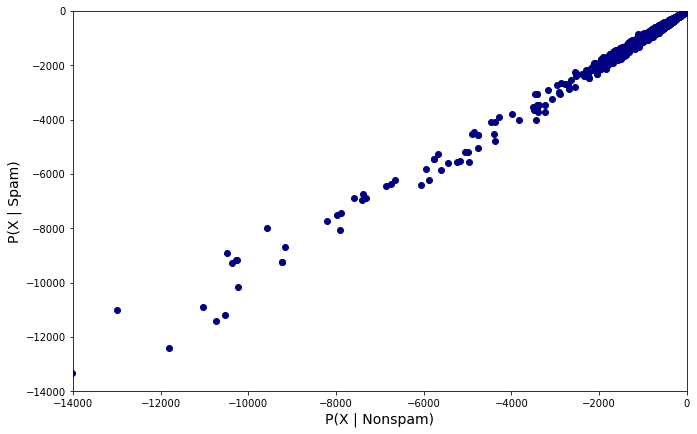

In [254]:
plt.figure(figsize=(11, 7))
plt.xlabel(xaxis_label, fontsize=14)
plt.ylabel(yaxis_label, fontsize=14)

# Set scale
plt.xlim([-14000, 1])
plt.ylim([-14000, 1])

plt.scatter(joint_log_ham, joint_log_spam, color='navy')
plt.show()

## The Decision Boundary

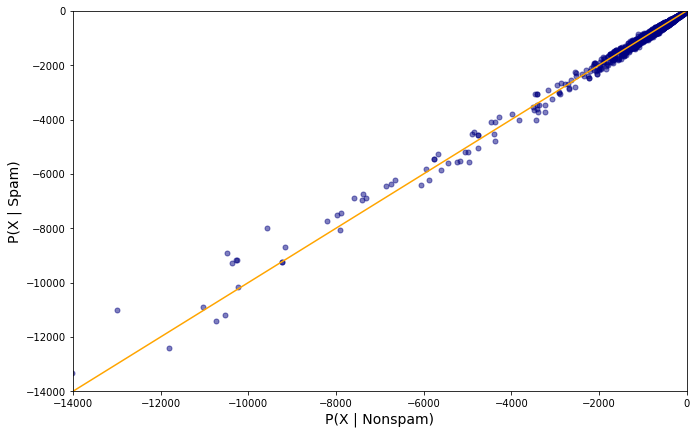

In [255]:
plt.figure(figsize=(11, 7))
plt.xlabel(xaxis_label, fontsize=14)
plt.ylabel(yaxis_label, fontsize=14)

# Set scale
plt.xlim([-14000, 1])
plt.ylim([-14000, 1])

plt.scatter(joint_log_ham, joint_log_spam, color='navy', alpha=0.5, s=25)
plt.plot(linedata, linedata, color='orange')

plt.show()

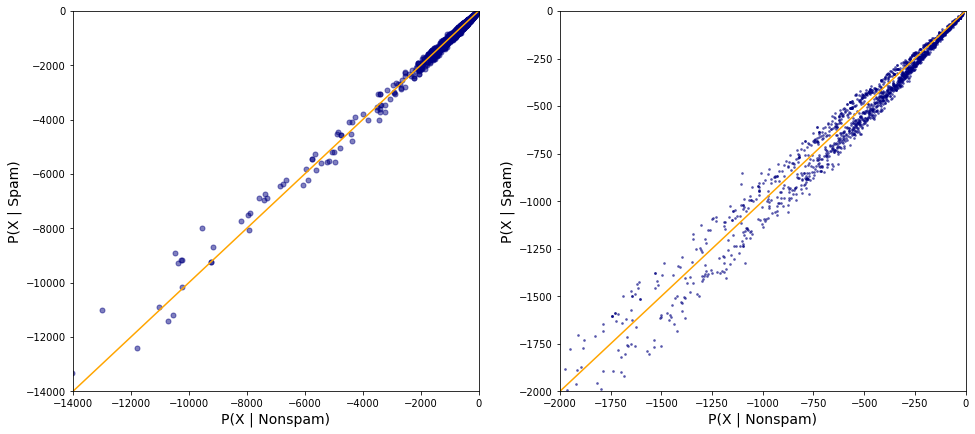

In [256]:
plt.figure(figsize=(16, 7))

# Chart Nr 1:
plt.subplot(1, 2, 1)

plt.xlabel(xaxis_label, fontsize=14)
plt.ylabel(yaxis_label, fontsize=14)

# Set scale
plt.xlim([-14000, 1])
plt.ylim([-14000, 1])

plt.scatter(joint_log_ham, joint_log_spam, color='navy', alpha=0.5, s=25)
plt.plot(linedata, linedata, color='orange')

# Chart Nr 2:
plt.subplot(1, 2, 2)

plt.xlabel(xaxis_label, fontsize=14)
plt.ylabel(yaxis_label, fontsize=14)

# Set scale
plt.xlim([-2000, 1])
plt.ylim([-2000, 1])

plt.scatter(joint_log_ham, joint_log_spam, color='navy', alpha=0.5, s=3)
plt.plot(linedata, linedata, color='orange')

plt.show()

In [257]:
# Chart Styling
sns.set_style('whitegrid')
labels = 'Actual Category'

summary_df = pd.DataFrame({yaxis_label: joint_log_spam, xaxis_label: joint_log_ham, 
                          labels: y_test})

/opt/conda/lib/python3.7/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


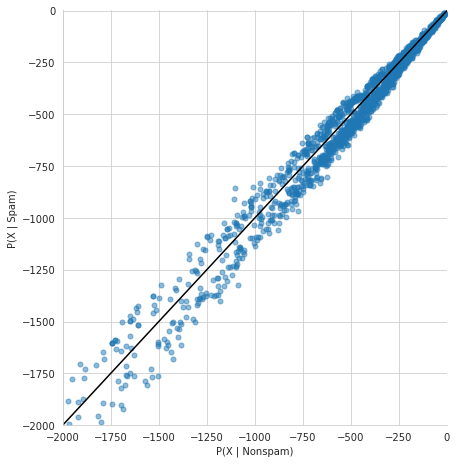

In [260]:
sns.lmplot(x=xaxis_label, y=yaxis_label, data=summary_df, size=6.5, fit_reg=False,
          scatter_kws={'alpha': 0.5, 's': 25})

plt.xlim([-2000, 1])
plt.ylim([-2000, 1])

plt.plot(linedata, linedata, color='black')

plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


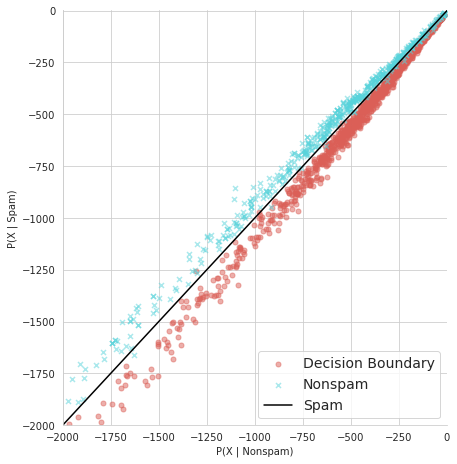

In [261]:
sns.lmplot(x=xaxis_label, y=yaxis_label, data=summary_df, size=6.5, fit_reg=False, legend=False,
          scatter_kws={'alpha': 0.5, 's': 25}, hue=labels, markers=['o', 'x'], palette='hls')

plt.xlim([-2000, 1])
plt.ylim([-2000, 1])

plt.plot(linedata, linedata, color='black')

plt.legend(('Decision Boundary', 'Nonspam', 'Spam'), loc='lower right', fontsize=14)

plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


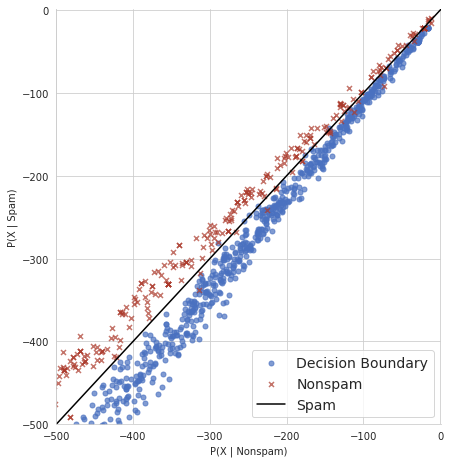

In [262]:
my_colours = ['#4A71C0', '#AB3A2C']

sns.lmplot(x=xaxis_label, y=yaxis_label, data=summary_df, size=6.5, fit_reg=False, legend=False,
          scatter_kws={'alpha': 0.7, 's': 25}, hue=labels, markers=['o', 'x'], palette=my_colours)

plt.xlim([-500, 1])
plt.ylim([-500, 1])

plt.plot(linedata, linedata, color='black')

plt.legend(('Decision Boundary', 'Nonspam', 'Spam'), loc='lower right', fontsize=14)

plt.show()

### False Positives and False Negatives

In [263]:
np.unique(prediction, return_counts=True)

(array([False,  True]), array([1161,  564]))

In [264]:
true_pos = (y_test == 1) & (prediction == 1)

In [265]:
true_pos.sum()

553

**Challenge:** Create a numpy array that measures the False Positives for each datapoint. Call this variable ```false_pos```. Then work out how many false positives there were. After you've done that, do the same for the false negatives. Store those in a variable called ```false_neg```

In [266]:
false_pos = (y_test == 0) & (prediction == 1)
false_pos.sum()

11

In [267]:
false_neg = (y_test == 1) & (prediction == 0)
false_neg.sum()

37

## Recall Score

**Challenge:** Calculate the recall score. Store it in a variable called ```recall_score```. Print the value of the recall score as a percentage rounded to two decimal places.

In [268]:
recall_score = true_pos.sum() / (true_pos.sum() + false_neg.sum())
print('Recall score is {:.2%}'.format(recall_score))

Recall score is 93.73%


## Precision Score

**Challenge:** Calculate the precision of our naive bayes model. Store the result in a variable called ```precision_score```. Print out the precision as a decimal number rounded to three decimal places. 

In [269]:
precision_score = true_pos.sum() / (true_pos.sum() + false_pos.sum())
print('Precision score is {:.3}'.format(precision_score))

Precision score is 0.98


## F-Score or F1 Score

In [270]:
f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)
print('F Score is {:.2}'.format(f1_score))

F Score is 0.96


In [272]:
data = pd.read_json(DATA_JSON_FILE)

In [273]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
5791,"For the past 2 days, nothing that I'm reportin...",0,00580.7dd943cb2a791ae9600144dee69f27b1
5792,"On Mon, Aug 12, 2002 at 11:06:18PM +0000, Ang...",0,01216.4dd33d22b4b0004c6b95b771c2881bcc
5793,"Well, it wouldn't be my own vanity list if I d...",0,00742.ce72d7c8245e881d6e0ee5d8e9cfabab
5794,http://spackle.xidus.net/info.php\n\n\n\n>>Fro...,0,00063.530734e4a37f26942ba8df3208912783
5795,"Check out this. Its for compaq kit, but a pc's...",0,00025.84faba510a966c90f6ca7658260a7e4c


In [274]:
data.shape

(5796, 3)

In [275]:
data.sort_index(inplace=True)

In [276]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
5791,"For the past 2 days, nothing that I'm reportin...",0,00580.7dd943cb2a791ae9600144dee69f27b1
5792,"On Mon, Aug 12, 2002 at 11:06:18PM +0000, Ang...",0,01216.4dd33d22b4b0004c6b95b771c2881bcc
5793,"Well, it wouldn't be my own vanity list if I d...",0,00742.ce72d7c8245e881d6e0ee5d8e9cfabab
5794,http://spackle.xidus.net/info.php\n\n\n\n>>Fro...,0,00063.530734e4a37f26942ba8df3208912783
5795,"Check out this. Its for compaq kit, but a pc's...",0,00025.84faba510a966c90f6ca7658260a7e4c


In [279]:
vectorizer = CountVectorizer(stop_words='english')

In [280]:
all_features = vectorizer.fit_transform(data.MESSAGE)

In [281]:
all_features.shape

(5796, 102694)

In [282]:
vectorizer.vocabulary_

{'multi': 63629,
 'message': 61680,
 'mime': 62140,
 'format': 42435,
 '_nextpart_000_143b1f_01c25a7a': 15048,
 'a80cb430': 15679,
 'content': 30249,
 'type': 89371,
 'text': 86991,
 'plain': 71912,
 'charset': 27796,
 'windows': 95603,
 '1252': 2025,
 'transfer': 88556,
 'encoding': 38472,
 'quoted': 75615,
 'printable': 73192,
 'tba': 86441,
 'doctor': 34857,
 'walks': 94102,
 'walk': 94096,
 'diabetes': 33886,
 '20': 3486,
 'case': 26890,
 'male': 60546,
 'age': 17749,
 '37': 6094,
 'nonsmoker': 65764,
 '500': 8927,
 '000': 1,
 'face': 40498,
 'diabetic': 33887,
 'treated': 88689,
 'insulin': 52241,
 'pump': 74078,
 'diagnosed': 33892,
 '23': 4214,
 'hospitalized': 48200,
 '95': 13787,
 '96': 13830,
 '98': 13914,
 'complications': 29685,
 'issued': 53136,
 'standard': 84076,
 '51': 9018,
 '200': 3487,
 '237lbs': 4292,
 'takes': 86235,
 'micronase': 61988,
 'glucophage': 44986,
 'super': 85106,
 '09': 844,
 'female': 41148,
 '60': 10038,
 '165lbs': 2523,
 'dependent': 33244,
 '45': 8

In [283]:
X_train, X_test, y_train, y_test = train_test_split(all_features, data.CATEGORY, 
                                                   test_size=0.3, random_state=88)

In [284]:
X_train.shape

(4057, 102694)

In [285]:
X_test.shape

(1739, 102694)

In [286]:
classifier = MultinomialNB()

In [287]:
classifier.fit(X_train, y_train)

MultinomialNB()

**Challenge:** Calculate the following for the test dataset: <br>
The number of documents classified correctly. <br>
The number of documents classified incorrectly. <br>
The accuracy of the model. <br>

In [288]:
nr_correct = (y_test == classifier.predict(X_test)).sum()

In [289]:
print(f'{nr_correct} documents classfied correctly')

1630 documents classfied correctly


In [290]:
nr_incorrect = y_test.size - nr_correct

In [291]:
print(f'Number of documents incorrectly classified is {nr_incorrect}')

Number of documents incorrectly classified is 109


In [292]:
fraction_wrong = nr_incorrect / (nr_correct + nr_incorrect)
print(f'The (testing) accuracy of the model is {1-fraction_wrong:.2%}')

The (testing) accuracy of the model is 93.73%


In [293]:
classifier.score(X_test, y_test)

0.9373202990224266

**Challenge:** For the testing dataset calculate the recall, precision and f1 score. Google for the scikit learn documentation on this topic to work it out. 

In [294]:
recall_score(y_test, classifier.predict(X_test))

0.8176895306859205

In [295]:
precision_score(y_test, classifier.predict(X_test))

0.982646420824295

In [296]:
f1_score(y_test, classifier.predict(X_test))

0.8926108374384236

In [297]:
example = ['get viagra for free now!', 
          'need a mortgage? Reply to arrange a call with a specialist and get a quote', 
          'Could you please help me with the project for tomorrow?', 
          'Hello Jonathan, how about a game of golf tomorrow?', 
          'Ski jumping is a winter sport in which competitors aim to achieve the longest jump after descending from a specially designed ramp on their skis. Along with jump length, competitor\'s style and other factors affect the final score. Ski jumping was first contested in Norway in the late 19th century, and later spread through Europe and North America in the early 20th century. Along with cross-country skiing, it constitutes the traditional group of Nordic skiing disciplines.'
          ]

In [298]:
doc_term_matrix = vectorizer.transform(example)

In [299]:
classifier.predict(doc_term_matrix)

array([1, 1, 0, 0, 0])

# Resource

https://www.udemy.com/course/python-data-science-machine-learning-bootcamp